In [1]:
!pip install shap

     |████████████████████████████████| 276kB 2.8MB/s 
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394123 sha256=15bb4889251748768b5f8a3d9e5857e2d105ac0a662a5d06d9f79f49edf2eb33
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap


In [2]:


from __future__ import print_function
import warnings
# Supress jupyter warnings if required for cleaner output
warnings.simplefilter('ignore')

import numpy as np
import itertools
import tensorflow as tf

from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.utils import to_categorical # convert to one-hot-encoding
from tensorflow.keras.models import Model, Sequential # Sequeantial layer addition
from sklearn.metrics import confusion_matrix
import shap
# Graphs
import pandas as pd
import matplotlib.colors as colors
import matplotlib.cm as mplcm
import matplotlib.pyplot as plt


In [3]:
print("tensorflow " + tf.__version__)
print("keras " +tf.keras.__version__)
print("shap " +shap.__version__)

tensorflow 2.3.0
keras 2.4.0
shap 0.35.0


In [4]:
# Load dataset
from keras.datasets import mnist
# Tuple of Numpy arrays: (x_train, y_train), (x_test, y_test).
(train, train_labels), (test, test_labels) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


# Analyzing data

Lets check the dimensions of arrays using numpys array attribute *shape*. Attribute tells us the dimesions of and array. In our case (60000, 28, 28). First number represents number of samples, second and third is dimensions of the image.





In [5]:
print(train.shape)
print(train_labels.shape)

print(test.shape)
print(test_labels.shape)

# save input image dimensions
img_rows = train.shape[1]
img_cols = train.shape[2]

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


Look at data examples.

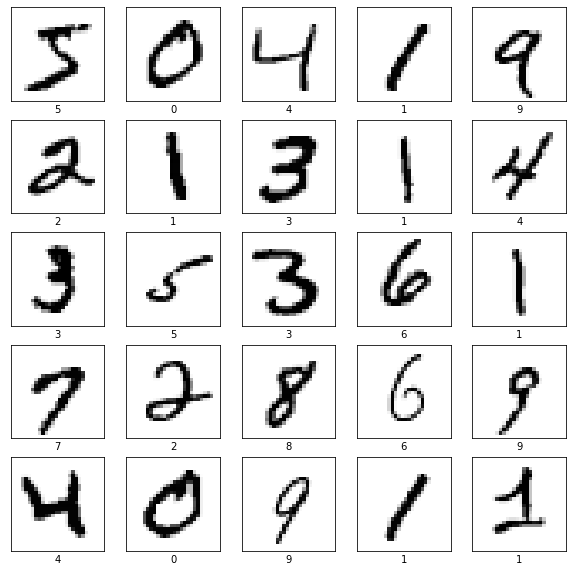

In [6]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train[i], cmap='Greys')
    plt.xlabel(str(train_labels[i]))

Get number of classes

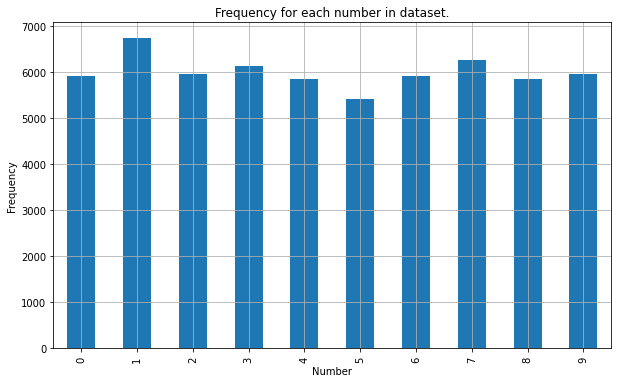

In [7]:
# Get classes and number of values
value_counts = pd.value_counts(train_labels).sort_index()
num_classes = value_counts.count()

# Plot
axes_subplot = plt.subplot()

axes_subplot.set_xlabel("Number")
axes_subplot.set_ylabel("Frequency")

value_counts.plot(kind='bar', 
                  title="Frequency for each number in dataset.",
                  figsize=(10,6),
                  grid="true")
plt.show()

From the graph, we can see that the number of instances for each class is very similar.

# Data manipulation

**Any training data manipulation must be done to testing data too.**


In preparation in using the data we have to reshape images to 3 dimensions (height, width, canal = 1). We are adding the last dimension because Keras requires color canal at the end.

Original 1D vector consisted of 784 values(28x28). We reshape all data to 3D matrices(28x28x1) which include canal. Our canal is equal to one, because we do not have RGB colored images.

For RGB images we would reshape to 28x28x3 3D matrices, where canal would be equal to three.

In [8]:
train = train.reshape(train.shape[0], img_rows, img_cols, 1)
test = test.reshape(test.shape[0], img_rows, img_cols, 1)

Perform grayscale normalization to reduce the effect of illumination's differences and speed up the convergence of CNN.

Division by 255 is because the pixels color can range from 0 - 255.



In [9]:
train = train/255
test = test/255

Now we have to encode labels to one hot vector. Our one hot vector will be 1x10. Example for label 4: [0,0,0,1,0,0,0,0,0,0]

In [10]:
# Encode labels to one hot vectors
train_labels  = to_categorical(train_labels , num_classes = num_classes)
test_labels   = to_categorical(test_labels  , num_classes = num_classes)


# The model

## Model creation

First step is to create empty sequential model. To the model we add 2D convolutional layer which takes the input image.

In [11]:
model = Sequential()


In [12]:
model.add(Conv2D(32, kernel_size = 4, activation="relu", input_shape=(img_rows,img_cols,1)))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size = 3, activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size = 2, activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation='softmax'))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 25, 25, 32)        544       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          16448     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0

## Train model

In [14]:
model.compile(loss='categorical_crossentropy',
      optimizer='adam',
      metrics=['accuracy'])


In [15]:
batch_size = 128
epochs = 1

hist =  model.fit(train, train_labels,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(test, test_labels))

469/469 [==============================] - 44s 93ms/step - loss: 0.3019 - accuracy: 0.9079 - val_loss: 0.0644 - val_accuracy: 0.9807


In [16]:
pred = model.predict(test)

score = model.evaluate(test, test_labels, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.06438157707452774
Test accuracy: 0.9807000160217285


# Get errors

In [17]:
test_labels_predicted_classes = np.argmax(pred,axis = 1) 
test_true = np.argmax(test_labels,axis = 1)

Helper function for displaying confusion matrix



In [18]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.colorbar()
    plt.tight_layout()

    tick_marks = np.arange(len(classes))

    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 
                 color="white" if cm[i, j] > thresh else "black")

    

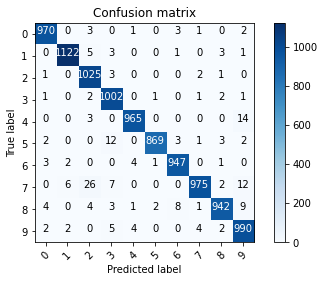

In [19]:
confusion_mtx = confusion_matrix(test_labels.argmax(axis=1) ,test_labels_predicted_classes)

plot_confusion_matrix(confusion_mtx, classes = range(10)) 

In [20]:
def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 10 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 5
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=(20, 8))
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1
    plt.show()

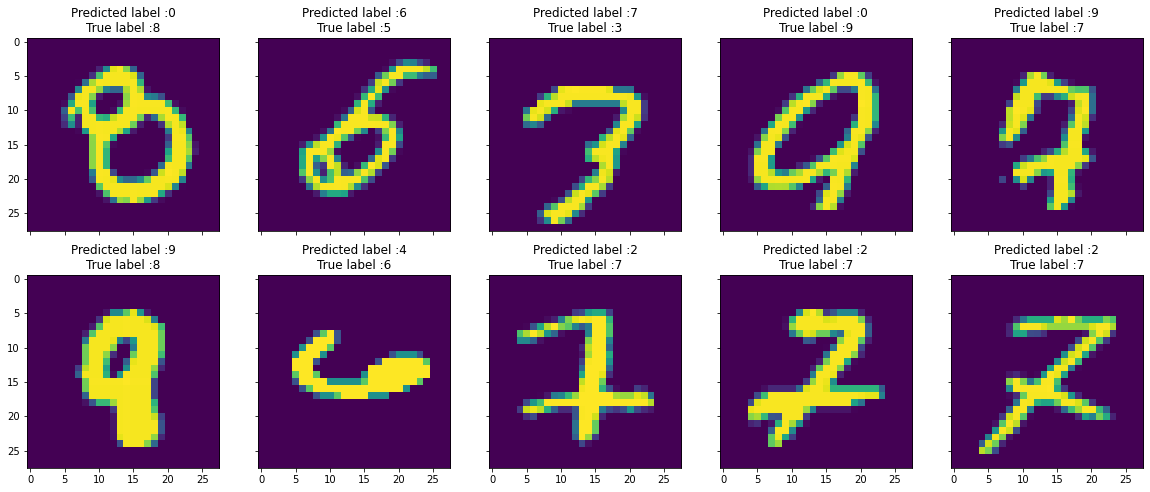

In [21]:
errors = (test_labels_predicted_classes - test_true != 0)

test_labels_classes_errors = test_labels_predicted_classes[errors]
test_labels_errors = pred[errors]
test_true_errors = test_true[errors]
test_errors = test[errors]


    
test_labels_errors_prob = np.max(test_labels_errors,axis = 1)
true_prob_errors = np.diagonal(np.take(test_labels_errors, test_true_errors, axis=1))
delta_pred_true_errors = test_labels_errors_prob - true_prob_errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)
most_important_errors = sorted_dela_errors[-10:]

display_errors(most_important_errors, test_errors, test_labels_classes_errors, test_true_errors)

# Explain

In [22]:
explainer = shap.DeepExplainer(model, (train[0:1000]))


Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
Predicted label :0
True label :8


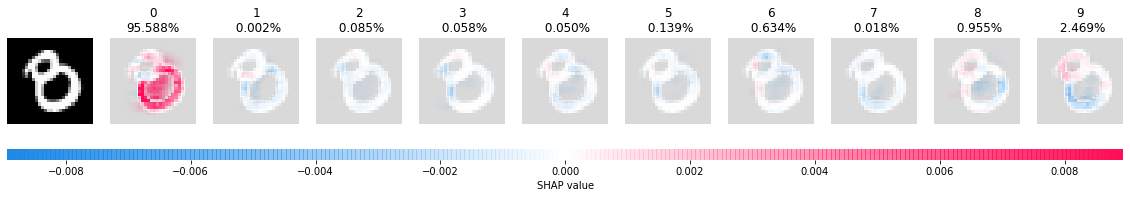

Predicted label :6
True label :5


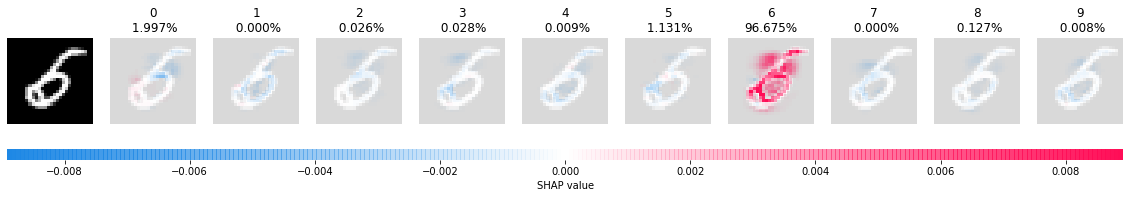

Predicted label :7
True label :3


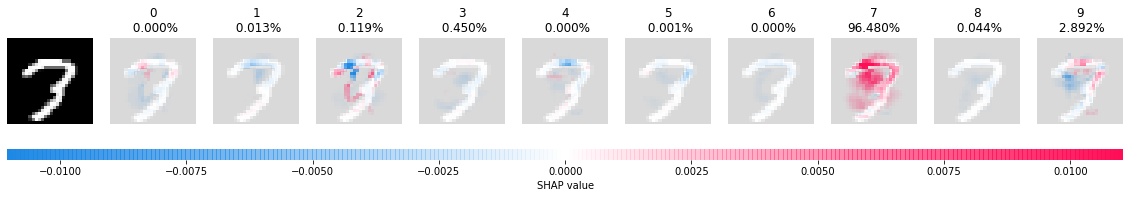

Predicted label :0
True label :9


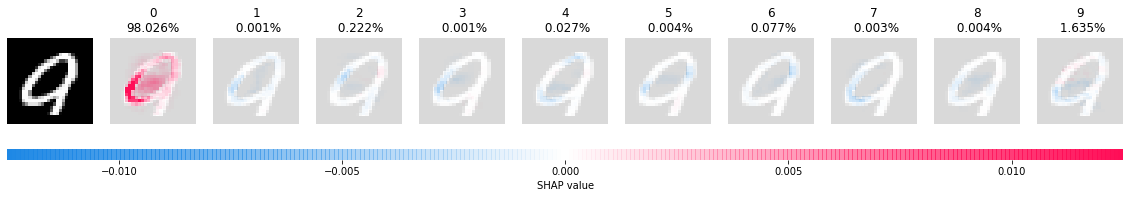

Predicted label :9
True label :7


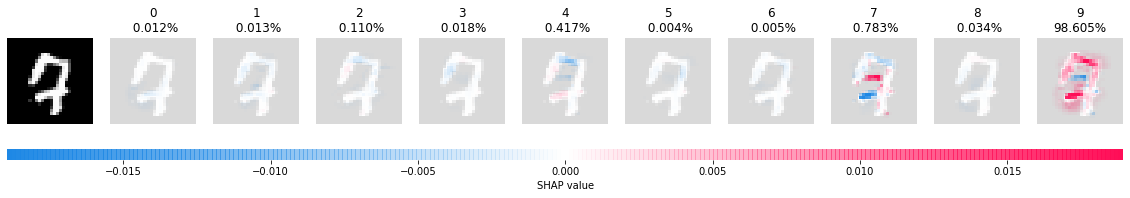

Predicted label :9
True label :8


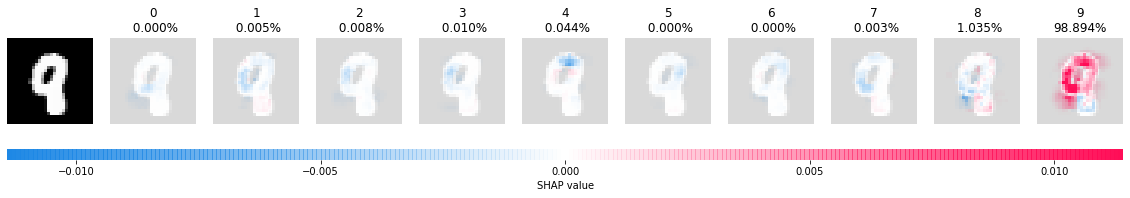

Predicted label :4
True label :6


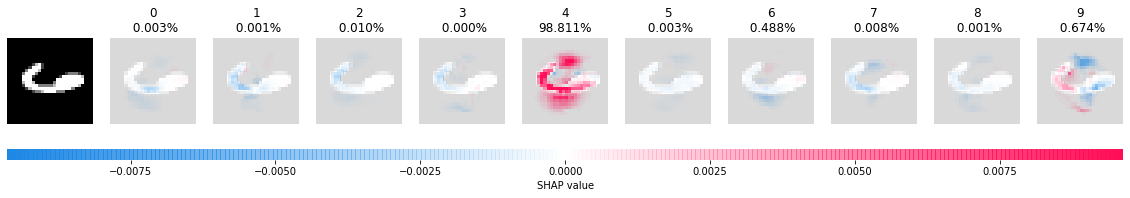

Predicted label :2
True label :7


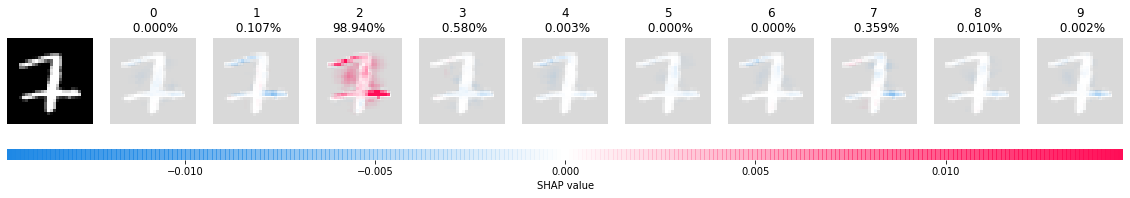

Predicted label :2
True label :7


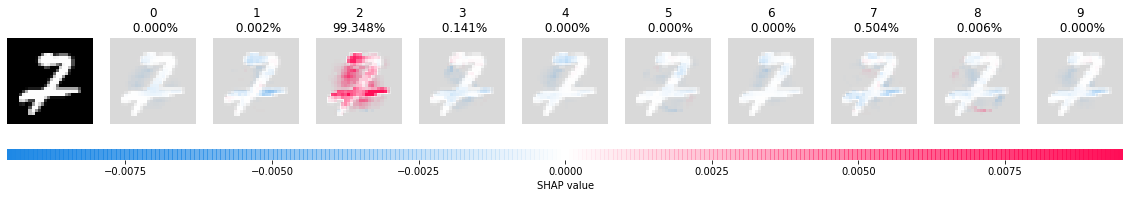

Predicted label :2
True label :7


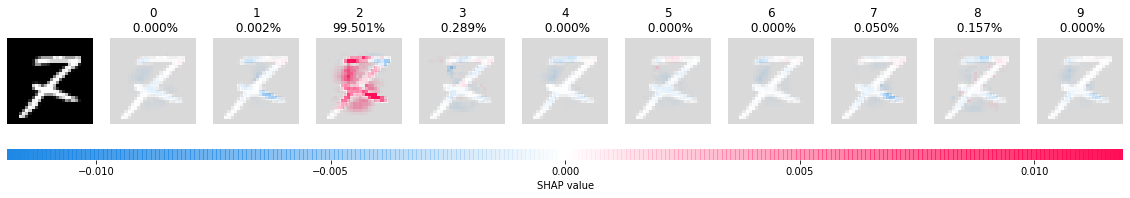

In [23]:
#Check out the 10 data that the model has mistakenly predicted.
for i in most_important_errors:

    #Calculates the SHAP value.
    shap_values = explainer.shap_values(test_errors[[i]])
    
    # Label
    index_names = np.array([str(x) + "\n" + '{:>7.3%}'.format(test_labels_errors[i][x]) for x in range(10)]).reshape(1,10)
    print("Predicted label :{}\nTrue label :{}".format(test_labels_classes_errors[i],test_true_errors[i]))
    
    #Displays the results.
    shap.image_plot(shap_values, test_errors[[i]] ,index_names ,show=False)
    plt.show()

Predicted label :7
True label :7


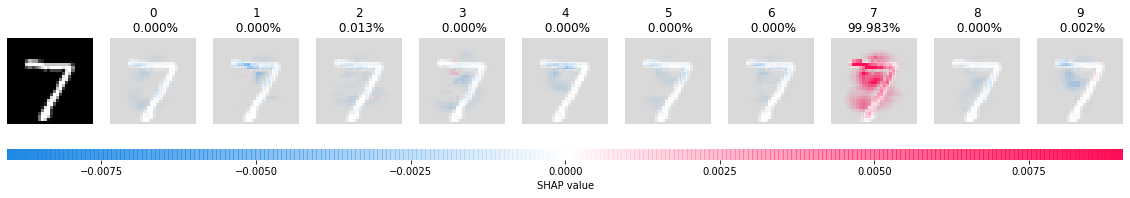

Predicted label :2
True label :2


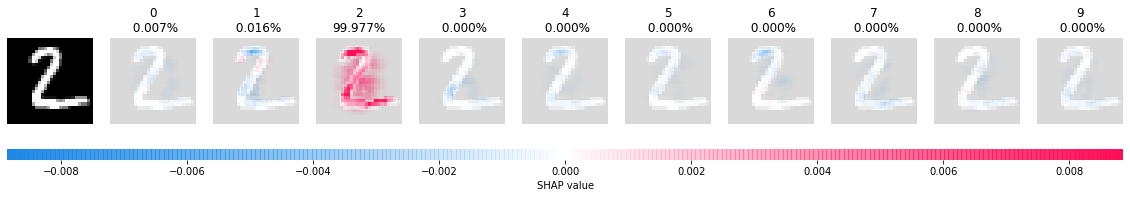

Predicted label :1
True label :1


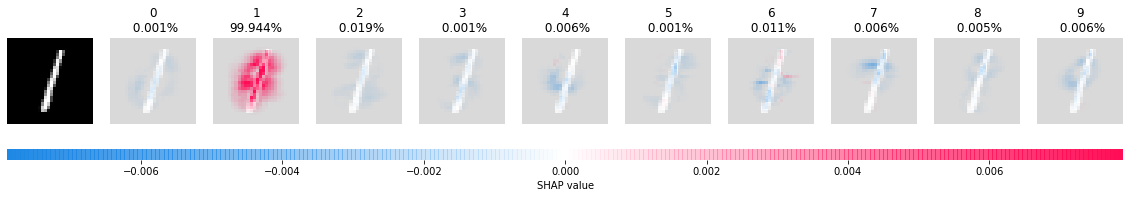

Predicted label :0
True label :0


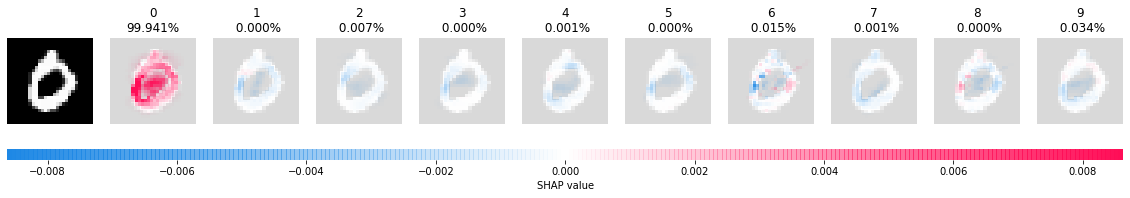

Predicted label :4
True label :4


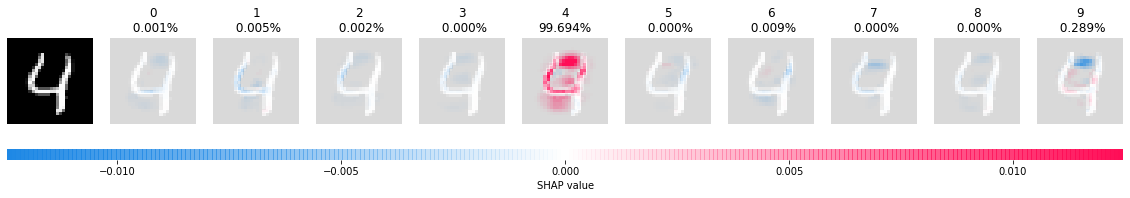

In [24]:
count = 0
for num in range(0,test.shape[0]) :
    if errors[num] == False:
        count += 1
        #Calculates the SHAP value.
        shap_values = explainer.shap_values(test[[num]])

        #Labels
        index_names = np.array([str(x) + "\n" + '{:>7.3%}'.format(pred[num][x]) for x in range(10)]).reshape(1,10)
        print("Predicted label :{}\nTrue label :{}".format(test_labels_predicted_classes[num],np.argmax(test_labels[num])))

        #Displays the results.
        shap.image_plot(shap_values, test[[num]] ,index_names ,show=False)
        plt.show()
        if count >= 5:
          break 